In [1]:
version = 'v20250521'

## read in data

In [2]:
# data
import pandas as pd
import numpy as np
df = pd.read_parquet(f'./material/srs_overlaid_{version}.pq')
print('original', df.shape)

original (10204, 1760)


In [3]:
crop_col = []
for ii in df.columns:
    if 'cropland' in ii:
        df.loc[df[ii].isna(),ii] = 0
        df.loc[df[ii]>0,ii] = 100
        crop_col.append(ii)

In [4]:
drop_col = []
for ii in df.columns:
    if 'evi' in ii: # remove the bimonthly
        drop_col.append(ii)
    # if 'nos' in ii:
    #     drop_col.append(ii)
    # if 'cdr' in ii:
    #     drop_col.append(ii)
    # if 'backscatter' in ii:
    #     drop_col.append(ii)
    # if 'palsar' in ii:
    #     drop_col.append(ii)
        
df = df.drop(columns=drop_col)
print(df.shape)

(10204, 1760)


In [5]:
## static cols
from skmap.misc import find_files, GoogleSheet, ttprint
# read in gsheet
gsheet_key = '/mnt/apollo/stac/gaia-319808-913d36b5fca4.json'
gsheet_url = 'https://docs.google.com/spreadsheets/d/1lNTpzdHBG5dirYj46iBDRJMk_YAV0Um2ovBc8v3dR9w/edit?gid=78425683#gid=78425683'
gsheet = GoogleSheet(gsheet_key, gsheet_url, verbose=False).soc_change_snr
sta = gsheet.loc[gsheet['type']=='common','layer_name'].values.tolist()

# sta.remove('soilsuite_mask')
# sta =  sta + ['soilsuite_bare','soilsuite_veg','soilsuite_other']

# static columns
scol = []
for ii in sta:
    if '{perc}' in ii:
        if 'glad' in ii:
            for perc in ['p25','p50','p75']:
                scol.append(ii.replace('{perc}',perc))
        elif 'moisture' in ii:
            for perc in ['p0.05','p0.5','p0.95']:
                scol.append(ii.replace('{perc}',perc))
        elif 'CHELSA' in ii:
            for perc in ['min','max','range','mean']:
                scol.append(ii.replace('{perc}',perc))
    else:
        scol.append(ii)

In [6]:
# temporal columns, other than static ones  
tcol = []
for ii in df.columns[21:]:
    if ii not in scol:
        if ii not in ['lon', 'lat']:
            tcol.append(ii)

In [7]:
# check nan columns
for ii in tcol+scol:
    m = df[ii].isna().sum()
    if m > 50:
        print(ii,m)
        
df = df.drop(columns=['CHELSA_swe_1981-2010_V.2.1'])
# df = df.dropna(subset=['palsar_hh_2015_eu','palsar_hv_2015_eu'])
print(df.shape)

CHELSA_swe_1981-2010_V.2.1 5701
palsar_hh_2015_eu 210
palsar_hv_2015_eu 192
(10204, 1759)


## feature engineer to reflect temporal process

In [8]:
from skmap.misc import find_files, GoogleSheet, ttprint
from scipy.stats import linregress
import warnings
warnings.filterwarnings("ignore")

def extract_time_series_features(ts):
    ts = np.array(ts)
    time = np.arange(len(ts))
    
    mean_val = np.mean(ts)
    std_val = np.std(ts)
    slope, _, _, _, _ = linregress(time, ts)
    autocorr_lag1 = np.corrcoef(ts[:-1], ts[1:])[0, 1] if len(ts) > 1 else np.nan
    
    return mean_val, std_val, slope, autocorr_lag1

df['start_idx'] = df['time_series'].apply(lambda x: int(x[0]) - 2000)
df['end_idx'] = df['time_series'].apply(lambda x: int(x[-1]) - 2000 + 1)



In [9]:
ttcol = [ii for ii in tcol if '_2000' in ii]
ttprint('start')
for it in ttcol:
    extract_cols = [it.replace('_2000', f'_{ival}') for ival in np.arange(2000,2024,1)]
        
    extract_cols = [col for col in extract_cols if col in df.columns]

    df['ts'] = df[extract_cols].apply(lambda x: x.values.astype(float).tolist(), axis=1)

    # Now slice the time series into pre and during, row-wise
    df['pre_ts'] = df.apply(lambda row: row['ts'][:row['start_idx']], axis=1)
    df['during_ts'] = df.apply(lambda row: row['ts'][row['start_idx']:row['end_idx']], axis=1)
    df['full_ts'] = df.apply(lambda row: row['ts'][:row['end_idx']], axis=1)

    # Feature extraction using apply
    df[[f'{it}_pre_mean', f'{it}_pre_std', f'{it}_pre_slope', f'{it}_pre_lag1']] = df['pre_ts'].apply(
        lambda x: pd.Series(extract_time_series_features(x))
    )

    df[[f'{it}_during_mean', f'{it}_during_std', f'{it}_during_slope', f'{it}_during_lag1']] = df['during_ts'].apply(
        lambda x: pd.Series(extract_time_series_features(x))
    )

    df[[f'{it}_full_mean', f'{it}_full_std', f'{it}_full_slope', f'{it}_full_lag1']] = df['full_ts'].apply(
        lambda x: pd.Series(extract_time_series_features(x))
    )

    df.drop(columns=extract_cols + ['pre_ts', 'during_ts', 'full_ts', 'ts'], inplace=True)

ttprint('finish')

df = df.drop(columns=['start_idx','end_idx'])
print(df.shape)
df.to_parquet('./material/series_feature.engineered.pq')

[20:00:44] start
[20:16:52] finish
(10204, 1234)


## mend missing files

In [29]:
import pandas as pd
df = pd.read_parquet('./material/series_feature.engineered.pq')
acol = df.columns[21:].values.tolist()
acol.remove('lat')
acol.remove('lon')

In [30]:
# drop all lag columsn, as there are too many nans
drop_col = []
drop_col = [ii for ii in df.columns if '_lag1' in ii]
df = df.drop(columns=drop_col)
for ii in drop_col:
    acol.remove(ii)
print(df.shape)

# drop all cols with invalid value > 50
drop_col = []
for ii in acol:
    m = df[ii].isna().sum()
    if m > 250:
        print(ii, m)
        drop_col.append(ii)
        
print(df.shape)
df = df.drop(columns = drop_col)
print(df.shape)

(10204, 1009)
(10204, 1009)
(10204, 1009)


In [32]:
# check other columns with missing values
drop_col = []
acol = df.columns[21:].values.tolist()
acol.remove('lat')
acol.remove('lon')

for ii in acol:
    m = df[ii].isna().sum()
    if m > 0:
        # print(ii, m)
        drop_col.append(ii)
        
df = df.dropna(subset=acol,how='any')
print(df.shape)

(9866, 1009)


## assign tile id

In [33]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
eu_tile = gpd.read_file('/home/xuemeng/work_xuemeng/soc/data/000_tiles.correct_epsg.3035.gpkg')
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.crs = 'EPSG:4326'
gdf = gdf.to_crs(eu_tile.crs)

joined_gdf = gpd.sjoin(gdf, eu_tile, how="left", op='within')
joined_gdf = joined_gdf.drop(columns=['geometry','index_right'])
joined_gdf = joined_gdf.rename(columns={'id_right':'tile_id','id_left':'id'})
df = joined_gdf
print(df.shape)

(9866, 1010)


## split the train test set

In [34]:
ttid = pd.read_csv(f'./material/srs.id_test_v20250521.txt', header=None)[0].tolist() 
print(len(ttid))
ttid = [str(i) for i in ttid]

1800


In [35]:
test = df.loc[df['id'].isin(ttid)]
print(test.shape)
test.to_parquet(f'./material/srs_test_{version}.pq')
other = df.loc[~df['id'].isin(ttid)]
cal = other.sample(1000, random_state=42)
cal.to_parquet(f'./material/srs_cal_{version}.pq')
print(cal.shape)
train = other.drop(cal.index)
print(train.shape)
train.to_parquet(f'./material/srs_train_{version}.pq')

(1742, 1010)
(1000, 1010)
(7124, 1010)


## check distribution

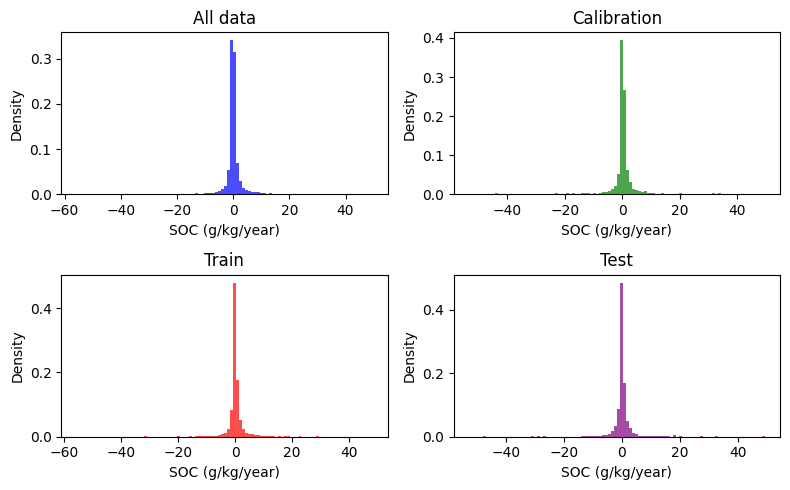

In [36]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(8, 5))

axes[0, 0].hist(df["ts_slope"], bins=100, alpha=0.7, color="blue", density=True)
axes[0, 0].set_title("All data")
axes[0, 0].set_xlabel("SOC (g/kg/year)")
axes[0, 0].set_ylabel("Density")

axes[0, 1].hist(cal["ts_slope"], bins=100, alpha=0.7, color="green", density=True)
axes[0, 1].set_title("Calibration")
axes[0, 1].set_xlabel("SOC (g/kg/year)")
axes[0, 1].set_ylabel("Density")

axes[1, 0].hist(train["ts_slope"], bins=100, alpha=0.7, color="red", density=True)
axes[1, 0].set_title("Train")
axes[1, 0].set_xlabel("SOC (g/kg/year)")
axes[1, 0].set_ylabel("Density")

axes[1, 1].hist(test["ts_slope"], bins=100, alpha=0.7, color="purple", density=True)
axes[1, 1].set_title("Test")
axes[1, 1].set_xlabel("SOC (g/kg/year)")
axes[1, 1].set_ylabel("Density")

plt.tight_layout()
plt.show()